## My project

# Introduction:

This notebook delves into the analysis of a comprehensive dataset comprising both fake and authentic news articles. The dataset encompasses various features, including article titles, textual content, and a 'type' label denoting whether the article is categorized as 'fake' or 'real'. The primary goal is to explore, preprocess, and derive insights from these articles, employing various analytical techniques and machine learning approaches.


## 1-Data

First we load the datasets and import the necessary libraries.

In [5]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [6]:
import pandas as pd
import numpy as np
import re
import nltk
import spacy
import string
pd.options.mode.chained_assignment = None
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from collections import Counter
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud

## Loading data

In [7]:
# Load the first CSV file
dfT = pd.read_csv('/content/drive/MyDrive/Data_NLP/data/True.csv')

# Load the second CSV file
dfF = pd.read_csv('/content/drive/MyDrive/Data_NLP/data/Fake.csv')

In [8]:
# For example, you can display the first few rows of each DataFrame
print("First DataFrame:")
print(f"Shape: {dfT.shape}")
print(dfT.head())

print("\nSecond DataFrame:")
print(f"Shape: {dfF.shape}")
print(dfF.head())

First DataFrame:
Shape: (21417, 4)
                                               title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  
0  December 31, 2017   
1  December 29, 2017   
2  December 31, 2017   
3  December 30, 2017   
4  December 29, 2017   

Second DataFrame:
Shape: (23481, 4)
                          

In [9]:
# Assigning labels
dfF['type'] = 'fake'
dfT['type'] = 'real'

# Removing duplicates
dfT = dfT.drop_duplicates()
dfF = dfF.drop_duplicates()

print(dfF.head())
print(dfT.head())

                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  type  
0  December 31, 2017  fake  
1  December 31, 2017  fake  
2  December 30, 2017  fake  
3  December 29, 2017  fake  
4  December 25, 2017  fake  
                                               title  \
0  As U.S. budget fight looms, Republicans flip 

In [10]:
# Rowbinding the fake and real articles into 1 df
data = pd.concat([dfF, dfT])

# Deleting unnecessary columns
data = data.drop(data.columns[[2, 3]], axis=1)

# Removing all text in all articles that comes before '(Reuters - )'
data['text'] = data['text'].apply(lambda x: x.split("(Reuters) - ")[1] if len(x.split("(Reuters) - ")) > 1 else x)

# Replacing apostrophes with spaces in the texts
data['text'] = data['text'].apply(lambda x: x.replace("’", ''))

# Real articles get label 1, fake get label 0
data["type"] = data["type"].apply(lambda x: 1 if x == "real" else 0)  # Assuming 'true' represents true articles

# Removing rows with articles containing title < 20 characters or text < 50 characters
min_title_length = 20
min_text_length = 50
data["title_length"] = data['title'].apply(len)
data["text_length"] = data['text'].apply(len)
data = data[(data.title_length > min_title_length) & (data.text_length > min_text_length)]

print(len(data))  # Outputting the length of the resulting DataFrame after filtering
print(data)


43842
                                                   title  \
0       Donald Trump Sends Out Embarrassing New Year’...   
1       Drunk Bragging Trump Staffer Started Russian ...   
2       Sheriff David Clarke Becomes An Internet Joke...   
3       Trump Is So Obsessed He Even Has Obama’s Name...   
4       Pope Francis Just Called Out Donald Trump Dur...   
...                                                  ...   
21412  'Fully committed' NATO backs new U.S. approach...   
21413  LexisNexis withdrew two products from Chinese ...   
21414  Minsk cultural hub becomes haven from authorities   
21415  Vatican upbeat on possibility of Pope Francis ...   
21416  Indonesia to buy $1.14 billion worth of Russia...   

                                                    text  type  title_length  \
0      Donald Trump just couldn t wish all Americans ...     0            79   
1      House Intelligence Committee Chairman Devin Nu...     0            69   
2      On Friday, it was revealed

In [11]:
title_data = data[["title", "type"]]
title_data = title_data.rename(columns={"title": "text"})
text_data = data[["text", "type"]]

# Defining a train and test split of the data
from sklearn.model_selection import train_test_split
train_title, test_title = train_test_split(title_data, test_size=0.1, random_state=42)
train_text, test_text = train_test_split(text_data, test_size=0.1, random_state=42)
train = pd.concat([train_title, train_text])
train.head()

,text,type
19999,UK's May 'receiving regular updates' on London...,1
13692,"France will no longer dictate to Africans, Mac...",1
5949,U.S. Senate Leader McConnell opposes lifting R...,1
4217,Watch Joe Biden Tells Us EXACTLY What Trump I...,0
5610,WOW: Duck Dynasty Star Phil Robertson Offers ...,0


## Preprocessing the data

Lower Casing

In [12]:
# Convert the text_df text column to lowercase
dfT["text"] = dfT["text"].str.lower()

print("After lowering:")
print(dfT.head().text.values)
dfT.head()

# Convert the text_df text column to lowercase
dfF["text"] = dfF["text"].str.lower()

print("After lowering:")
print(dfF.head().text.values)
dfF.head()

After lowering:
['washington (reuters) - the head of a conservative republican faction in the u.s. congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on sunday and urged budget restraint in 2018. in keeping with a sharp pivot under way among republicans, u.s. representative mark meadows, speaking on cbs’ “face the nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in january. when they return from the holidays on wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the november congressional election campaigns approach in which republicans will seek to keep control of congress. president donald trump and his republicans want a big budget increase in military spending, while democrats also want proportional increases for non-defense “discretionary” spending on programs th

,title,text,subject,date,type
0,Donald Trump Sends Out Embarrassing New Year’...,donald trump just couldn t wish all americans ...,News,"December 31, 2017",fake
1,Drunk Bragging Trump Staffer Started Russian ...,house intelligence committee chairman devin nu...,News,"December 31, 2017",fake
2,Sheriff David Clarke Becomes An Internet Joke...,"on friday, it was revealed that former milwauk...",News,"December 30, 2017",fake
3,Trump Is So Obsessed He Even Has Obama’s Name...,"on christmas day, donald trump announced that ...",News,"December 29, 2017",fake
4,Pope Francis Just Called Out Donald Trump Dur...,pope francis used his annual christmas day mes...,News,"December 25, 2017",fake


Removal of punctuation

In [13]:
# Function to remove punctuation and convert text to lowercase
def remove_punctuation(text):
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Convert to lowercase
    text = text.lower()
    return text

# Apply the clean_text function to a DataFrame's 'text' column
def clean_and_print(df):
    df["text"] = df["text"].apply(remove_punctuation)
    print("After cleaning:")
    print(df.head().text.values)
    return df.head()

# for test
dataTest = {"text": ["Hello, World!", "ABCabc!!!!!!!..,;,,;,;."]}


dfT = pd.DataFrame(dfT)
dfF = pd.DataFrame(dfF)

# Apply the cleaning function to the DataFrames
clean_and_print(dfT)
clean_and_print(dfF)


After cleaning:
['washington reuters  the head of a conservative republican faction in the us congress who voted this month for a huge expansion of the national debt to pay for tax cuts called himself a “fiscal conservative” on sunday and urged budget restraint in 2018 in keeping with a sharp pivot under way among republicans us representative mark meadows speaking on cbs’ “face the nation” drew a hard line on federal spending which lawmakers are bracing to do battle over in january when they return from the holidays on wednesday lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues such as immigration policy even as the november congressional election campaigns approach in which republicans will seek to keep control of congress president donald trump and his republicans want a big budget increase in military spending while democrats also want proportional increases for nondefense “discretionary” spending on programs that support education 

,title,text,subject,date,type
0,Donald Trump Sends Out Embarrassing New Year’...,donald trump just couldn t wish all americans ...,News,"December 31, 2017",fake
1,Drunk Bragging Trump Staffer Started Russian ...,house intelligence committee chairman devin nu...,News,"December 31, 2017",fake
2,Sheriff David Clarke Becomes An Internet Joke...,on friday it was revealed that former milwauke...,News,"December 30, 2017",fake
3,Trump Is So Obsessed He Even Has Obama’s Name...,on christmas day donald trump announced that h...,News,"December 29, 2017",fake
4,Pope Francis Just Called Out Donald Trump Dur...,pope francis used his annual christmas day mes...,News,"December 25, 2017",fake


In [14]:
# Download stopwords if not already downloaded
nltk.download('stopwords')

# Function to remove punctuation, stopwords, and convert text to lowercase
def remove_punctuation_and_stopwords(text):
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Convert to lowercase
    text = text.lower()
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = text.split()
    text = " ".join([word for word in words if word not in stop_words])
    return text

# Apply the remove_punctuation_and_stopwords function to a DataFrame's 'text' column
def clean_and_print(df):
    df["text"] = df["text"].apply(remove_punctuation_and_stopwords)
    print("After cleaning:")
    print(df.head().text.values)
    return df.head()

# Create a sample DataFrame
dataTest = {"text": ["Hello, World!", "ABCabc!!!!!!!..,;,,;,;."]}

dfT = pd.DataFrame(dfT)
dfF = pd.DataFrame(dfF)

# Apply the cleaning function to the DataFrame
clean_and_print(dfT)
clean_and_print(dfF)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


After cleaning:
['washington reuters head conservative republican faction us congress voted month huge expansion national debt pay tax cuts called “fiscal conservative” sunday urged budget restraint 2018 keeping sharp pivot way among republicans us representative mark meadows speaking cbs’ “face nation” drew hard line federal spending lawmakers bracing battle january return holidays wednesday lawmakers begin trying pass federal budget fight likely linked issues immigration policy even november congressional election campaigns approach republicans seek keep control congress president donald trump republicans want big budget increase military spending democrats also want proportional increases nondefense “discretionary” spending programs support education scientific research infrastructure public health environmental protection “the trump administration already willing say ‘we’re going increase nondefense discretionary spending 7 percent’” meadows chairman small influential house freedom

,title,text,subject,date,type
0,Donald Trump Sends Out Embarrassing New Year’...,donald trump wish americans happy new year lea...,News,"December 31, 2017",fake
1,Drunk Bragging Trump Staffer Started Russian ...,house intelligence committee chairman devin nu...,News,"December 31, 2017",fake
2,Sheriff David Clarke Becomes An Internet Joke...,friday revealed former milwaukee sheriff david...,News,"December 30, 2017",fake
3,Trump Is So Obsessed He Even Has Obama’s Name...,christmas day donald trump announced would bac...,News,"December 29, 2017",fake
4,Pope Francis Just Called Out Donald Trump Dur...,pope francis used annual christmas day message...,News,"December 25, 2017",fake


### Cleaning function





In [15]:
# Download stopwords if not already downloaded
nltk.download('stopwords')

# Initialize the Porter Stemmer
stemmer = PorterStemmer()

# Function to remove punctuation, stopwords, and perform stemming
def preprocess_text(text, remove_punctuation=True, remove_stopwords=True, perform_stemming=True):
    if remove_punctuation:
        text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.lower()

    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        words = text.split()
        words = [word for word in words if word not in stop_words]
        text = " ".join(words)

    if perform_stemming:
        words = text.split()
        stemmed_words = [stemmer.stem(word) for word in words]
        text = " ".join(stemmed_words)

    return text

# Apply the preprocess_text function to a DataFrame's 'text' column
def clean_and_print(df, remove_punctuation=True, remove_stopwords=True, perform_stemming=True):
    df["text"] = df["text"].apply(lambda text: preprocess_text(text, remove_punctuation, remove_stopwords, perform_stemming))
    print("After preprocessing:")
    print(df.head().text.values)
    return df.head()

# Preprocess text in the DataFrames
clean_and_print(dfT, remove_punctuation=True, remove_stopwords=True, perform_stemming=True)
clean_and_print(dfF, remove_punctuation=True, remove_stopwords=True, perform_stemming=True)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


After preprocessing:
['washington reuter head conserv republican faction us congress vote month huge expans nation debt pay tax cut call “fiscal conservative” sunday urg budget restraint 2018 keep sharp pivot way among republican us repres mark meadow speak cbs’ “face nation” drew hard line feder spend lawmak brace battl januari return holiday wednesday lawmak begin tri pass feder budget fight like link issu immigr polici even novemb congression elect campaign approach republican seek keep control congress presid donald trump republican want big budget increas militari spend democrat also want proport increas nondefens “discretionary” spend program support educ scientif research infrastructur public health environment protect “the trump administr alreadi will say ‘we’r go increas nondefens discretionari spend 7 percent’” meadow chairman small influenti hous freedom caucu said program “now democrat say that’ enough need give govern pay rais 10 11 percent fiscal conserv don’t see rationa

,title,text,subject,date,type
0,Donald Trump Sends Out Embarrassing New Year’...,donald trump wish american happi new year leav...,News,"December 31, 2017",fake
1,Drunk Bragging Trump Staffer Started Russian ...,hous intellig committe chairman devin nune go ...,News,"December 31, 2017",fake
2,Sheriff David Clarke Becomes An Internet Joke...,friday reveal former milwauke sheriff david cl...,News,"December 30, 2017",fake
3,Trump Is So Obsessed He Even Has Obama’s Name...,christma day donald trump announc would back w...,News,"December 29, 2017",fake
4,Pope Francis Just Called Out Donald Trump Dur...,pope franci use annual christma day messag reb...,News,"December 25, 2017",fake


## Text analysis Frequent Words

The most used words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


the most comment words in true news are :
said: 97822
trump: 41686
us: 40371
state: 34428
would: 31062
reuter: 28012
presid: 26793
republican: 21635
govern: 19423
year: 17801
hous: 17113
new: 16555
unit: 16257
democrat: 15892
also: 15735
say: 15598
senat: 15193
elect: 15139
offici: 14612
peopl: 14474

the most comment words in fake news are :
said: 97822
trump: 41686
us: 40371
state: 34428
would: 31062
reuter: 28012
presid: 26793
republican: 21635
govern: 19423
year: 17801
hous: 17113
new: 16555
unit: 16257
democrat: 15892
also: 15735
say: 15598
senat: 15193
elect: 15139
offici: 14612
peopl: 14474


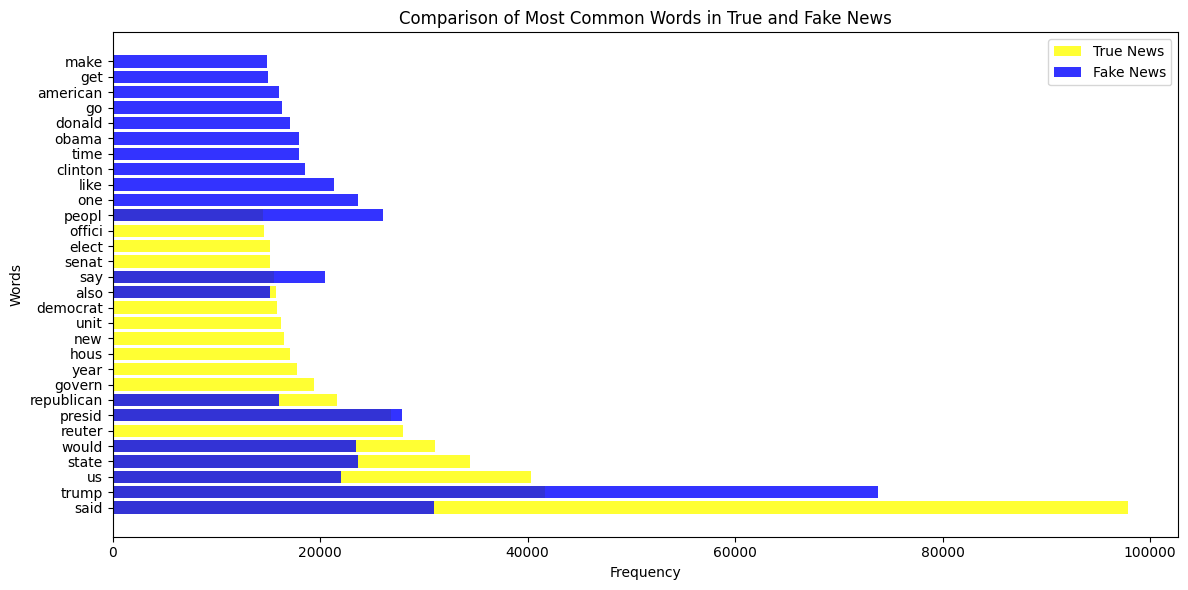

In [16]:
# Download stopwords if not already downloaded
nltk.download('stopwords')

# Function to tokenize and preprocess text
def preprocess_text(text):
    # Remove punctuation and convert to lowercase
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.lower()
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return words



# Combine all text into a single string
combined_text = " ".join(dfT["text"].astype(str))

# Tokenize and preprocess the text
wordsT = preprocess_text(combined_text)

# Count word frequencies
word_countT = Counter(wordsT)

# Get the 20 most common words
most_common_wordsT = word_countT.most_common(20)

# Print the 20 most common words
print("the most comment words in true news are :")
for word, count in most_common_wordsT:
    print(f'{word}: {count}')

# Combine all text into a single string
combined_text = " ".join(dfF["text"].astype(str))

# Tokenize and preprocess the text
wordsF = preprocess_text(combined_text)

# Count word frequencies
word_countF = Counter(wordsF)

# Get the 20 most common words
most_common_wordsF = word_countF.most_common(20)

# Print the 20 most common words
print("\nthe most comment words in fake news are :")
for word, count in most_common_wordsT:
    print(f'{word}: {count}')

# Extract words and counts for plotting
wordsT, countsT = zip(*most_common_wordsT)
wordsF, countsF = zip(*most_common_wordsF)

# Create bar charts to compare the most common words
plt.figure(figsize=(12, 6))
plt.barh(wordsT, countsT, color='yellow', label='True News', alpha=0.8)
plt.barh(wordsF, countsF, color='blue', label='Fake News', alpha=0.8)
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('Comparison of Most Common Words in True and Fake News')
plt.legend()
plt.tight_layout()
plt.show()

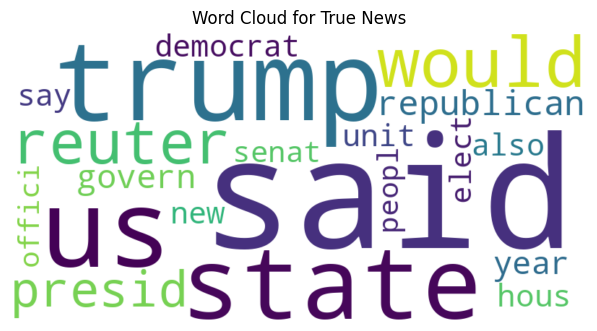

In [17]:
# Word cloud for True News
wordcloud_true = WordCloud(width=800, height=400, max_words=200, background_color='white').generate_from_frequencies(dict(most_common_wordsT))

# Word cloud for Fake News
wordcloud_fake = WordCloud(width=800, height=400, max_words=200, background_color='white').generate_from_frequencies(dict(most_common_wordsF))

# Displaying the word clouds
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)  # Subplot for True News
plt.imshow(wordcloud_true, interpolation='bilinear')
plt.title('Word Cloud for True News')
plt.axis('off')



plt.tight_layout()
plt.show()


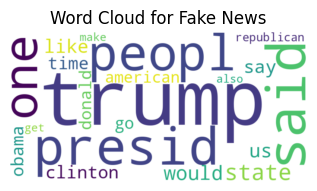

In [18]:
plt.subplot(1, 2, 2)  # Subplot for Fake News
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.title('Word Cloud for Fake News')
plt.axis('off')

plt.tight_layout()
plt.show()

### Text analysis Sentiment analysis


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


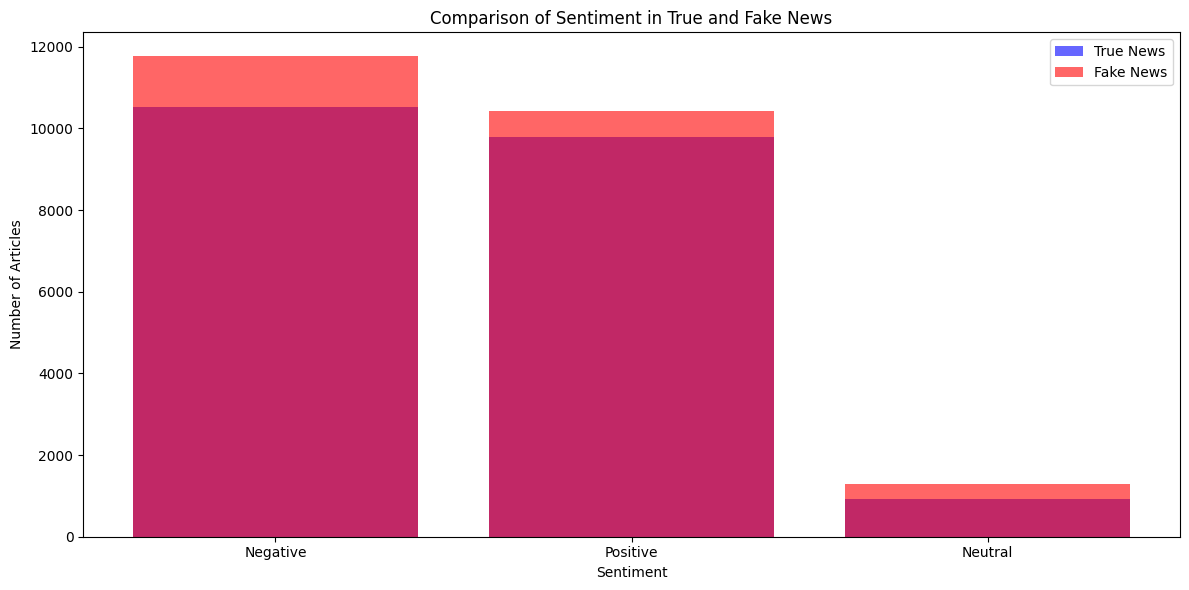

In [19]:
# Download VADER lexicon if not already downloaded
nltk.download('vader_lexicon')

# Create a SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Function to classify sentiment
def classify_sentiment(text):
    sentiment_scores = analyzer.polarity_scores(text)
    if sentiment_scores['compound'] >= 0.05:
        return 'Positive'
    elif sentiment_scores['compound'] <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Classify the sentiment for each news article
dfT['Sentiment'] = dfT['text'].apply(classify_sentiment)
dfF['Sentiment'] = dfF['text'].apply(classify_sentiment)

# Count the number of articles in each sentiment category
true_sentiment_counts = dfT['Sentiment'].value_counts()
fake_sentiment_counts = dfF['Sentiment'].value_counts()

# Create bar charts to compare the sentiment distribution
plt.figure(figsize=(12, 6))
plt.bar(true_sentiment_counts.index, true_sentiment_counts.values, color='blue', label='True News', alpha=0.6)
plt.bar(fake_sentiment_counts.index, fake_sentiment_counts.values, color='red', label='Fake News', alpha=0.6)
plt.xlabel('Sentiment')
plt.ylabel('Number of Articles')
plt.title('Comparison of Sentiment in True and Fake News')
plt.legend()
plt.tight_layout()



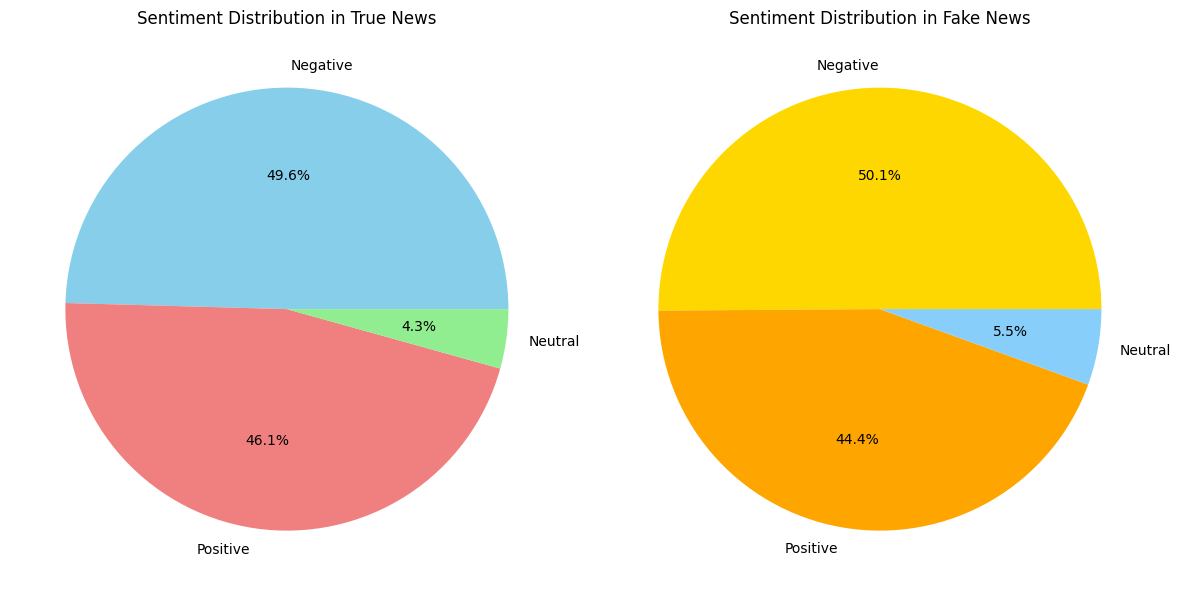

In [20]:
# Create pie charts to visualize the sentiment distribution with adjusted colors
plt.figure(figsize=(12, 6))

# Colors for the pie charts
true_colors = ['skyblue', 'lightcoral', 'lightgreen']  # Example colors for True News
fake_colors = ['gold', 'orange', 'lightskyblue']  # Example colors for Fake News

plt.subplot(121)  # Left subplot for True News
plt.pie(true_sentiment_counts, labels=true_sentiment_counts.index, autopct='%1.1f%%', colors=true_colors)
plt.title('Sentiment Distribution in True News')

plt.subplot(122)  # Right subplot for Fake News
plt.pie(fake_sentiment_counts, labels=fake_sentiment_counts.index, autopct='%1.1f%%', colors=fake_colors)
plt.title('Sentiment Distribution in Fake News')

plt.tight_layout()
plt.show()


### Tokenisation

##  Model fitting

In [24]:
!pip install transformers
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 48.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 34.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 64.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 60.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.4 MB/s eta 0:00:00


In [25]:
from transformers import TFBertModel
import tensorflow as tf
from tensorflow import keras
from transformers import AutoTokenizer, DataCollatorWithPadding
from datasets import Dataset

In [26]:
MAX_LENGTH = 512 # maximum length that is used by the tokenizer
BATCH_SIZE = 16 # batch size that is used while transforming to tensorflow dataset

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf", max_length=MAX_LENGTH, padding='max_length')

# Tokenizes the text in the row
def tokenize_function(row):
    return tokenizer(row["text"], truncation=True, max_length=MAX_LENGTH)

# Tokenizes a df and turns into a tensorflow dataset format
def tokenize_DataFrame(df):
    tokenized_dataset = Dataset.from_pandas(df).map(tokenize_function, batched=False)
    tf_dataset = tokenized_dataset.to_tf_dataset(
        columns=["attention_mask", "input_ids", "token_type_ids"],
        label_cols=["type"],
        shuffle=False,
        collate_fn=data_collator,
        batch_size=BATCH_SIZE
    )
    return tf_dataset

# Tokenizes our test/train for our title/text datasets
tf_train_title = tokenize_DataFrame(train_title)
tf_test_title = tokenize_DataFrame(test_title)
tf_train_text = tokenize_DataFrame(train_text)
tf_test_text = tokenize_DataFrame(test_text)

Map:   0%|          | 0/39457 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:400: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Map:   0%|          | 0/4385 [00:00<?, ? examples/s]

Map:   0%|          | 0/39457 [00:00<?, ? examples/s]

Map:   0%|          | 0/4385 [00:00<?, ? examples/s]

In [27]:
# Define the input layers for the BERT model
input_ids         = keras.layers.Input(shape=(MAX_LENGTH, ), dtype=tf.int64)
attention_masks   = keras.layers.Input(shape=(MAX_LENGTH, ), dtype=tf.int64)
token_type        = keras.layers.Input(shape=(MAX_LENGTH, ), dtype=tf.int64)

# Load the BERT model from the pretrained "bert-base-uncased" model and set it to be non-trainable
bert_model = TFBertModel.from_pretrained("bert-base-uncased")
bert_model.trainable = False

# Apply the BERT model to the input layers to get the BERT output sequence
bert_output = bert_model.bert(input_ids, attention_mask=attention_masks, token_type_ids=token_type)
sequence_output = bert_output.last_hidden_state

# Build the bidirectional RNN that takes the BERT sequences as inputs
LSTM     = keras.layers.LSTM(64, return_sequences=True)
bi_lstm  = keras.layers.Bidirectional(LSTM)(sequence_output)

# Pool the bi-LSTM output sequences into features by taking the average and maximum of the sequences
avg_pool = keras.layers.GlobalAveragePooling1D()(bi_lstm)
max_pool = keras.layers.GlobalMaxPooling1D()(bi_lstm)

# Concatenate the average and maximum pooling features
concat   = keras.layers.concatenate([avg_pool, max_pool])

# Apply dropout and a dense layer with sigmoid activation to predict the label
dropout  = keras.layers.Dropout(0.3)(concat)
output   = keras.layers.Dense(1, activation="sigmoid")(dropout)

# Build the model with the input and output layers
model = keras.models.Model({'input_ids':input_ids, 'token_type_ids':token_type, 'attention_mask':attention_masks}, output)

# Print the summary of the model
model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 512)]                0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 512)]                0         []                            
                                                                                                  
 bert (TFBertMainLayer)      TFBaseModelOutputWithPooli   1094822   ['input_1[0][0]',             
                             ngAndCrossAttentions(last_   40         'input_2[0][0]',         

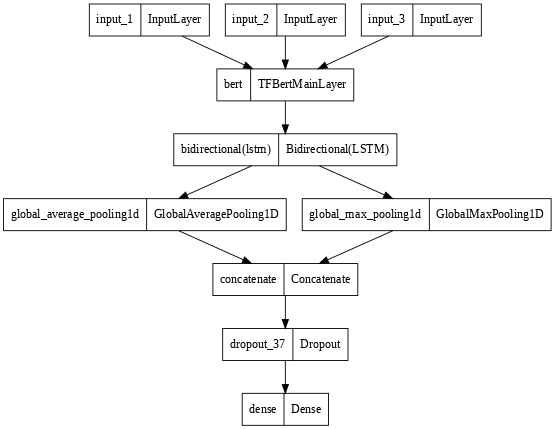

In [28]:
keras.utils.plot_model(model, dpi=64)

In [29]:
!apt-get install graphviz
!pip install pydot
!pip install graphviz


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.


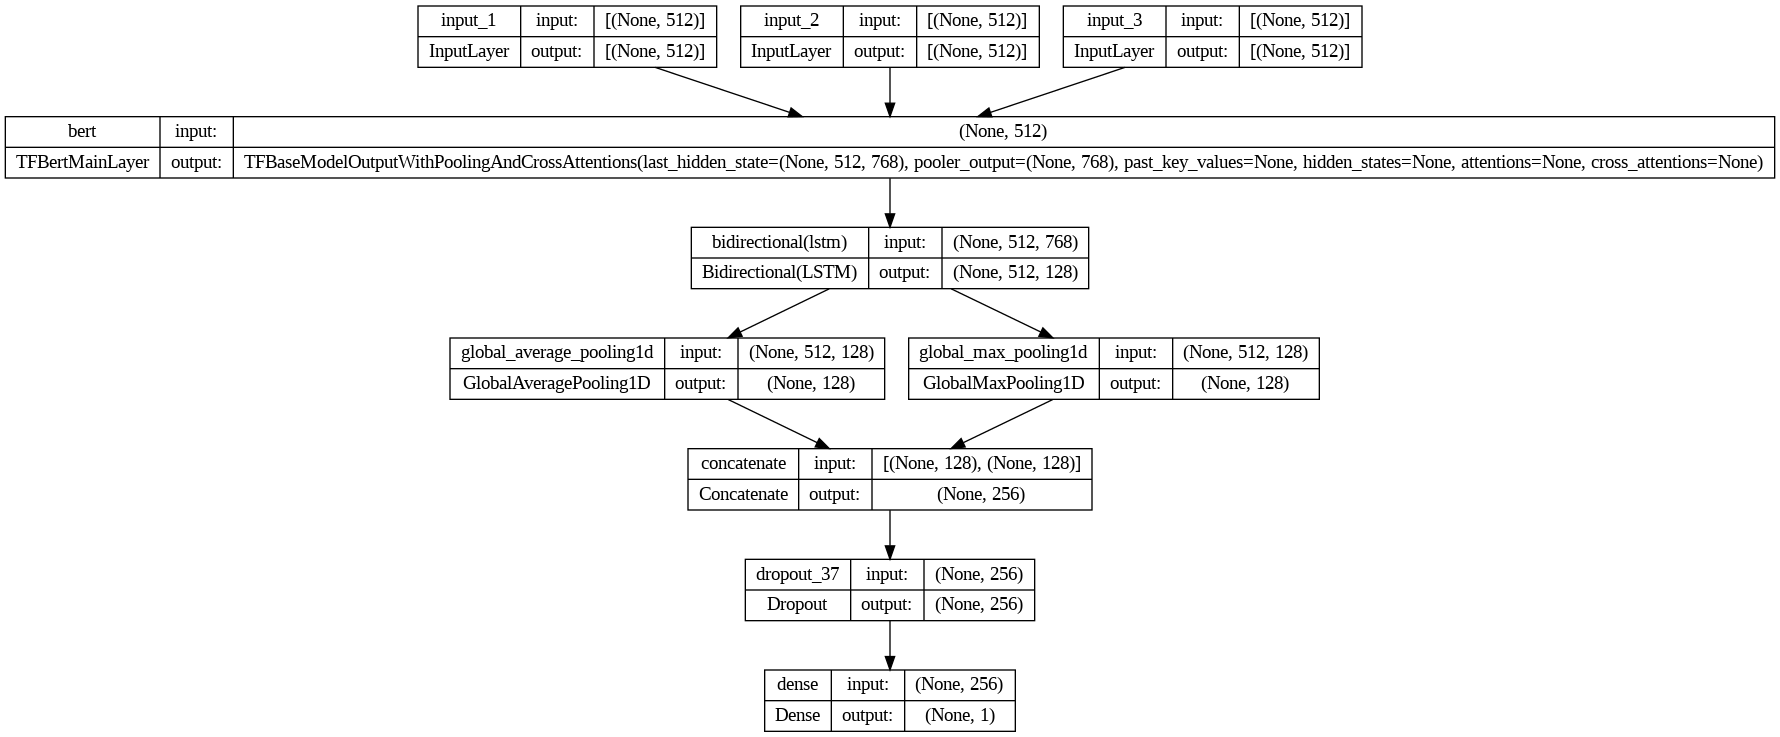

In [30]:
from keras.utils import plot_model

# Save the model architecture as an image file
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
from IPython.display import Image

Image('model_plot.png')


In [31]:
EPOCHS = 100

# Uncomment if you want to load the pre-trained weights back
#model.load_weights("/kaggle/input/bert-weights/weights_16.h5")
model.load_weights("/content/drive/MyDrive/Data_NLP/data/weights_16.h5")
# Keras Callback that will save the weights after each epoch
class SaveWeights(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        self.model.save_weights('text_weights_{}.h5'.format(epoch))

# Compiling our model
model.compile(tf.keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

#model.fit(tf_train_text, epochs=EPOCHS, callbacks=[SaveWeights()], validation_data=tf_test_text)

In [32]:
print(data)

                                                   title  \
0       Donald Trump Sends Out Embarrassing New Year’...   
1       Drunk Bragging Trump Staffer Started Russian ...   
2       Sheriff David Clarke Becomes An Internet Joke...   
3       Trump Is So Obsessed He Even Has Obama’s Name...   
4       Pope Francis Just Called Out Donald Trump Dur...   
...                                                  ...   
21412  'Fully committed' NATO backs new U.S. approach...   
21413  LexisNexis withdrew two products from Chinese ...   
21414  Minsk cultural hub becomes haven from authorities   
21415  Vatican upbeat on possibility of Pope Francis ...   
21416  Indonesia to buy $1.14 billion worth of Russia...   

                                                    text  type  title_length  \
0      Donald Trump just couldn t wish all Americans ...     0            79   
1      House Intelligence Committee Chairman Devin Nu...     0            69   
2      On Friday, it was revealed that 

In [33]:
def get_prediction(article):
    df = pd.DataFrame(data={
        "text": article
    }, index=[0])

In [ ]:
# standard performance measures for binary classification
def performance_measures(df, predictions):
    df["prediction"] = np.int32(np.round(predictions))  # round to get 0, 1 label predictions
    true_positive = len(df[(df.type == 1) & (df.prediction == 1)])
    true_negative = len(df[(df.type == 0) & (df.prediction == 0)])
    false_positive = len(df[(df.type == 1) & (df.prediction == 0)])
    false_negative = len(df[(df.type == 0) & (df.prediction == 1)])

    precision = true_positive / (true_positive + false_positive)
    recall = true_positive / (true_positive + false_negative)
    print("Precision\t", precision)
    print("Recall\t\t", recall)
    print("F1\t\t", 2 * (precision * recall) / (precision + recall))
    print("Accuracy\t", (true_positive + true_negative) / len(df))
    return df

df = performance_measures(test_title, model.predict(tf_test_title))

In [ ]:
#Testing the model on a different data file
#Tokenizing the new data

covid_data = pd.read_csv('/content/drive/MyDrive/Data_NLP/data/english_test_with_labels.xls')

# Removing duplicates
covid_data = covid_data.drop_duplicates()

# Replacing apostrophes with spaces in the texts
covid_data['tweet'] = covid_data['tweet'].apply(lambda x: x.replace("’", ''))

# Real articles get label 1, fake get label 0
covid_data["label"] = covid_data["label"].apply(lambda x: 1 if x == "real" else 0)

# Renameing label to type
covid_data = covid_data.rename(columns={"label": "type", "tweet": "text"})

covid_data = covid_data[["text", "type"]]

covid_data.head()

In [ ]:
tf_covid = tokenize_DataFrame(covid_data)
print("Covid tweet performance")
df = performance_measures(covid_data, model.predict(tf_covid))

## machine learning with tensor flow

In [ ]:
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from gensim.models import Word2Vec

# Download stopwords if not already downloaded
nltk.download('stopwords')

# Initialize the Porter Stemmer
stemmer = PorterStemmer()

# Function to remove punctuation, stopwords, and perform stemming
def preprocess_text(text, remove_punctuation=True, remove_stopwords=True, perform_stemming=True):
    if remove_punctuation:
        text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.lower()

    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        words = text.split()
        words = [word for word in words if word not in stop_words]
        text = " ".join(words)

    if perform_stemming:
        words = text.split()
        stemmed_words = [stemmer.stem(word) for word in words]
        text = " ".join(stemmed_words)

    return text

# Preprocess text in the DataFrames
dfT["text"] = dfT["text"].apply(preprocess_text)
dfF["text"] = dfF["text"].apply(preprocess_text)

# Tokenize the preprocessed text
sentencesT = [text.split() for text in dfT["text"]]
sentencesF = [text.split() for text in dfF["text"]]

# Train Word2Vec models on the tokenized sentences
modelT = Word2Vec(sentencesT, vector_size=100, window=5, min_count=1, sg=0)
modelF = Word2Vec(sentencesF, vector_size=100, window=5, min_count=1, sg=0)


In [35]:
from sklearn.model_selection import train_test_split

df = pd.read_csv('/content/drive/MyDrive/Data_NLP/data/english_test_with_labels.xls')

# Create labels for true and fake news (0 for true, 1 for fake)
#df['label'] = 0  # Label true news as 0
#df.loc[df.index >= len(dfT), 'label'] = 1  # Label fake news as 1
df["label"] = df["label"].apply(lambda x: 1 if x == "real" else 0)
# Split the dataset into features (X) and labels (y)
X = df['tweet']
y = df['label']

# Split the data into training and testing sets (e.g., 80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(df)

        id                                              tweet  label
0        1  Our daily update is published. States reported...      1
1        2             Alfalfa is the only cure for COVID-19.      0
2        3  President Trump Asked What He Would Do If He W...      0
3        4  States reported 630 deaths. We are still seein...      1
4        5  This is the sixth time a global health emergen...      1
...    ...                                                ...    ...
2135  2136  #CoronaVirusUpdates: State-wise details of Tot...      1
2136  2137  Tonight 12(midnight) onwards Disaster Manageme...      0
2137  2138  296 new cases of #COVID19Nigeria; Plateau-85 E...      1
2138  2139  RT @CDCemergency: #DYK? @CDCgov’s One-Stop Sho...      1
2139  2140  More than half of pregnant women recently admi...      1

[2140 rows x 3 columns]


In [36]:
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Create a TF-IDF vectorizer to convert text data to numerical features
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Build a Logistic Regression model
logistic_regression_model = LogisticRegression()
logistic_regression_model.fit(X_train_tfidf, y_train)

# Predict labels for the test set
y_pred = logistic_regression_model.predict(X_test_tfidf)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Print the results
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Confusion Matrix:")
print(confusion)
print("Classification Report:")
print(report)

Accuracy: 90.65%
Confusion Matrix:
[[170  23]
 [ 17 218]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.88      0.89       193
           1       0.90      0.93      0.92       235

    accuracy                           0.91       428
   macro avg       0.91      0.90      0.91       428
weighted avg       0.91      0.91      0.91       428



In [37]:
import multiprocessing
# Train a Word2Vec model
sentences = [text.split() for text in df["tweet"]]
cores = multiprocessing.cpu_count()  # Number of CPU cores to use
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, sg=0, workers=cores)

# Save the Word2Vec model
word2vec_model.save("word2vec.model")


In [38]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# Padding sequences to have the same length
max_sequence_length = max([len(seq) for seq in X_train_sequences])
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sequence_length, padding='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_sequence_length, padding='post')

# Load the Word2Vec model
word2vec_model = Word2Vec.load("word2vec.model")

# Create an embedding matrix using the Word2Vec model
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, word2vec_model.vector_size))
for word, i in tokenizer.word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]

# Build a deep learning model
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=word2vec_model.vector_size, weights=[embedding_matrix], input_length=max_sequence_length, trainable=False))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_padded, y_train, validation_data=(X_test_padded, y_test), epochs=5, batch_size=32)

# Evaluate the model's performance
accuracy = model.evaluate(X_test_padded, y_test)[1]
print("Accuracy: {:.2f}%".format(accuracy * 100))


Epoch 1/5
54/54 [==============================] - 21s 362ms/step - loss: 0.6619 - accuracy: 0.6723 - val_loss: 0.5966 - val_accuracy: 0.7243
Epoch 2/5
54/54 [==============================] - 19s 355ms/step - loss: 0.5970 - accuracy: 0.7185 - val_loss: 0.5976 - val_accuracy: 0.7173
Epoch 3/5
54/54 [==============================] - 11s 206ms/step - loss: 0.5705 - accuracy: 0.7290 - val_loss: 0.5887 - val_accuracy: 0.7243
Epoch 4/5
54/54 [==============================] - 20s 373ms/step - loss: 0.5499 - accuracy: 0.7284 - val_loss: 0.5888 - val_accuracy: 0.7126
Epoch 5/5
14/14 [==============================] - 0s 26ms/step - loss: 0.5939 - accuracy: 0.7313
Accuracy: 73.13%


In [39]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# Padding sequences to have the same length
max_sequence_length = max([len(seq) for seq in X_train_sequences])
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sequence_length, padding='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_sequence_length, padding='post')

# Load the Word2Vec model (assuming you have already trained it)
word2vec_model = Word2Vec.load("word2vec.model")

# Create an embedding matrix using the Word2Vec model
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, word2vec_model.vector_size))
for word, i in tokenizer.word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]

# Build a deep learning model
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=word2vec_model.vector_size, weights=[embedding_matrix], input_length=max_sequence_length, trainable=False))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_padded, y_train, validation_data=(X_test_padded, y_test), epochs=5, batch_size=32)

# Make predictions
y_pred = model.predict(X_test_padded)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert to binary predictions (0 or 1)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print("Accuracy: {:.2f}%".format(accuracy * 100))

# Calculate precision
precision = precision_score(y_test, y_pred_binary)
print("Precision: {:.2f}".format(precision))

# Calculate recall
recall = recall_score(y_test, y_pred_binary)
print("Recall: {:.2f}".format(recall))

# Calculate F1 score
f1 = f1_score(y_test, y_pred_binary)
print("F1 Score: {:.2f}".format(f1))


Epoch 1/5
54/54 [==============================] - 13s 228ms/step - loss: 0.6619 - accuracy: 0.6665 - val_loss: 0.5965 - val_accuracy: 0.7243
Epoch 2/5
54/54 [==============================] - 11s 196ms/step - loss: 0.5979 - accuracy: 0.7150 - val_loss: 0.5730 - val_accuracy: 0.7313
Epoch 3/5
54/54 [==============================] - 11s 195ms/step - loss: 0.5893 - accuracy: 0.7167 - val_loss: 0.5765 - val_accuracy: 0.7173
Epoch 4/5
54/54 [==============================] - 11s 204ms/step - loss: 0.5634 - accuracy: 0.7290 - val_loss: 0.5913 - val_accuracy: 0.6916
Epoch 5/5
14/14 [==============================] - 1s 43ms/step
Accuracy: 73.13%
Precision: 0.74
Recall: 0.78
F1 Score: 0.76


Confusion Matrix:
[[130  63]
 [ 52 183]]


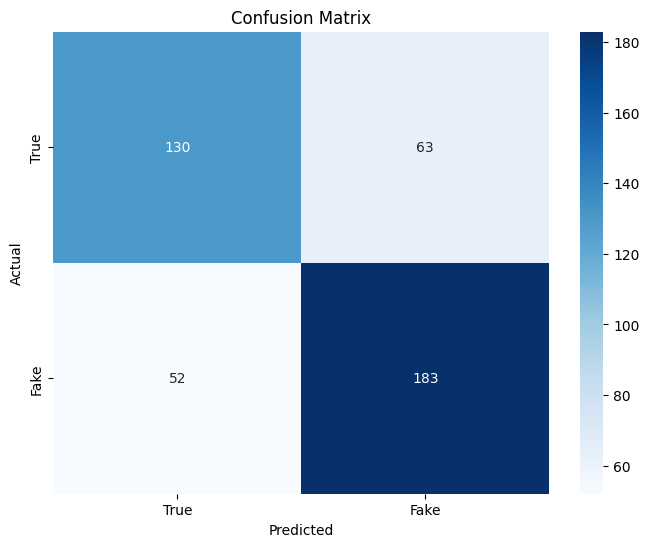

In [40]:
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from gensim.models import Word2Vec
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["True", "Fake"], yticklabels=["True", "Fake"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

from sklearn.metrics import roc_curve, auc

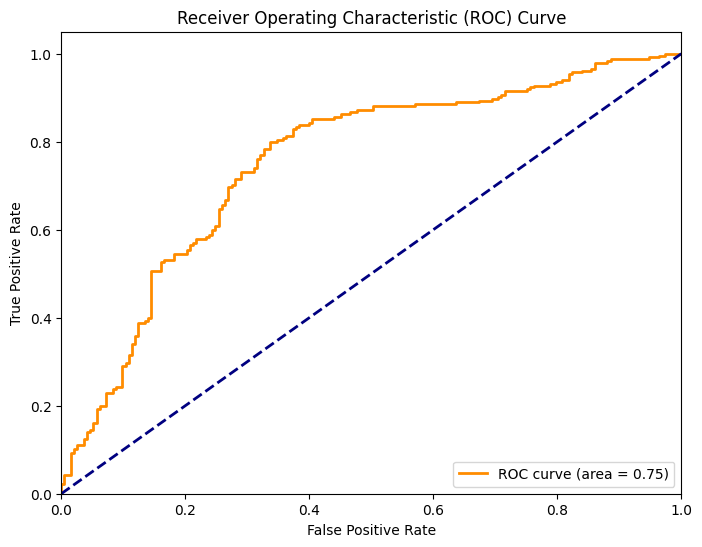

In [41]:
# You can plot the ROC curve to visualize the trade-off between the true positive rate (sensitivity) and the false positive rate. This curve can help you understand how well your model discriminates between classes.

from sklearn.metrics import roc_curve, auc

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


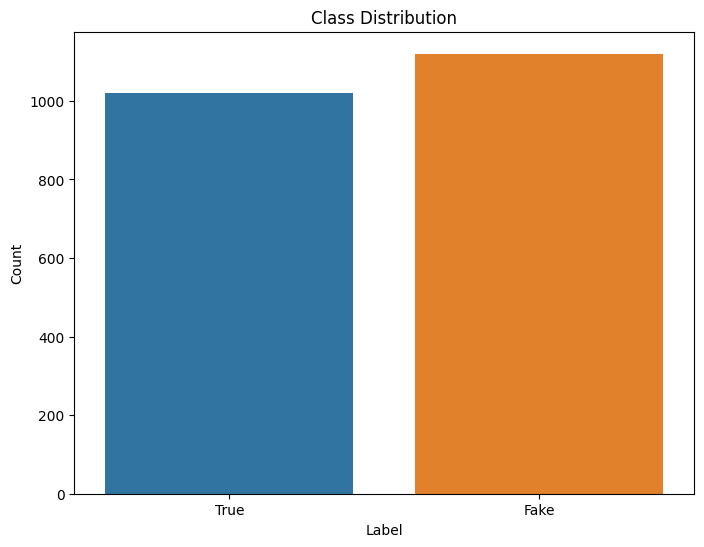

In [42]:
# You can visualize the distribution of the true and predicted labels to see how balanced or imbalanced your dataset is.
from sklearn.metrics import precision_recall_curve

# Visualize class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x="label", data=df)
plt.xticks([0, 1], ["True", "Fake"])
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Class Distribution")
plt.show()


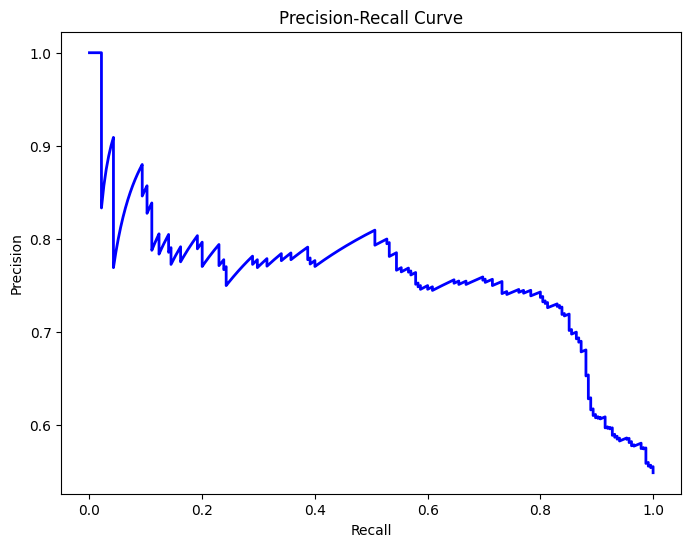

In [43]:
# This curve shows the trade-off between precision and recall for different thresholds. It's particularly useful when dealing with imbalanced datasets.
from sklearn.metrics import precision_recall_curve

# Calculate precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()
